In [272]:
#run this command if not installed
#!pip install dwave_qbsolv

### Required Modules

In [273]:
#to visualize the network and easy handling of graphs I am using networkx
import networkx as gp
import matplotlib.pyplot as plt

In [274]:
#firstly using classical solver to solve
#QBSolv uses tabu search algorithm which a clasical algorithm to solve QUBO matrix problems
from dwave_qbsolv import QBSolv

In [275]:
#using inbuilt function to find shortest path
#help(gp.shortest_simple_paths)

In [276]:
#we will use pairwise function to convert the continuous nodes (representing path) into edges (where each edge is a node pair)
l= [1,2,4,5,2,4]
ed = list(gp.utils.pairwise(l))
print(ed)

[(1, 2), (2, 4), (4, 5), (5, 2), (2, 4)]


### Sample Input Data

In [277]:
#sample data - to be read from file
#total number of nodes
num_nodes = 6
#Edges are given as u,v,congestion where edges is from u to v and its congestion level is given by the attribute congestion
edges = [
    (0,1,{'congestion':30}),
    (0,2,{'congestion':120}),
    (1,3,{'congestion':21}),
    (1,4,{'congestion':5}),
    (2,4,{'congestion':100}),
    (2,5,{'congestion':44}),
    (3,4,{'congestion':20}),
    (4,2,{'congestion':54})
]
#total number of cars to reroute
no_of_cars = 2
#source-destination pair of each car
src_dest = [(0,4),(0,5)]

## Graph formation using NetworkX

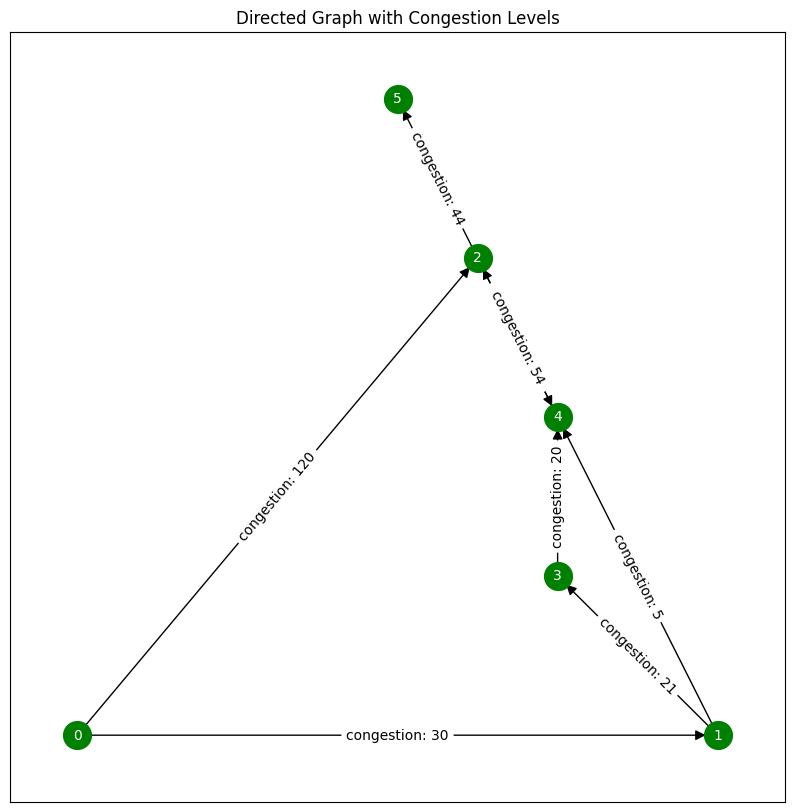

In [278]:
#forming the city's network
#adding nodes
net = gp.DiGraph()
net.add_edges_from(edges)
plt.figure(figsize=(10,10))
pos = gp.planar_layout(net)
gp.draw_networkx_nodes(net, pos, node_color='green', node_size=400)
gp.draw_networkx_edges(net, pos, arrowstyle='-|>', arrowsize=15)
edge_labels = {(u, v): f'congestion: {d["congestion"]}' for u, v, d in net.edges(data=True)}
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels)
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white')
plt.title("Directed Graph with Congestion Levels")
plt.show()

### Alternative Routes

In [279]:
def jcs(paths):
    return paths
    
def alternativeRoutes(no_of_cars, sd):
    '''finds all the simple paths from source to destination for each car'''
    routes = []
    for i in range(no_of_cars):
        k_paths = list(gp.shortest_simple_paths(net, source = sd[i][0], target=sd[i][1], weight = 'congestion'))
        k_paths = jcs(k_paths)
        routes.append(k_paths)
    return routes
    #return [[[0,1,4],[0,1,3,4],[0,2,4]],[[0,2,5],[0,1,3,4,5],[0,1,4,5]]]

In [280]:
routes  = alternativeRoutes(no_of_cars,src_dest )
print("Source-Destination Pairs for Rerouting:")
for src, dest in src_dest:
    print(f"Car starting from {src} to {dest}")
print('\nAlternative Routes :\n')
for i in range(1,3):
    print(f'Possible Routes for Car {i}')
    for ch in range(0,3):
        l=[]
        for path in routes[i-1][ch]:
            l.append(str(path))
        c="->"
        print(c.join(l))
        print()

Source-Destination Pairs for Rerouting:
Car starting from 0 to 4
Car starting from 0 to 5

Alternative Routes :

Possible Routes for Car 1
0->1->4

0->1->3->4

0->2->4

Possible Routes for Car 2
0->1->4->2->5

0->2->5

0->1->3->4->2->5



### Helping Functions

In [281]:
def nodeToEdge(node_routes,no_of_car, no_of_route):
    '''the function convert the route in nodes format to edge format (pairwise nodes as shown above)'''
    edge_route = []
    for i in range(no_of_car):
        car_route = []
        for j in range(no_of_route):
                car_route.append(list(gp.utils.pairwise(node_routes[i][j])))
        edge_route.append(car_route)
    return edge_route

In [282]:
def getOverlappingEdges(route1, route2):
    '''the function returns a list of overlapping edges (pairwise-nodes)'''
    overlaps =[]
    for r1 in route1:
        if r1 in route2:
            overlaps.append(r1)
    return overlaps

In [283]:
def getUni(route):
    uni = []
    for edge in route:
        if edge not in uni:
            uni.append(edge)
    return uni

In [284]:
def matrixWeight(routes, no_of_car, no_of_routes):
        Q_weight ={}
        tot_var = no_of_car * no_of_routes
        for i in range(tot_var):
            for j in range(tot_var):
                #currently assigning weight 1 to all the variables
                Q_weight.update({(i,j):1})
        return Q_weight

In [285]:
def displayMatrix(Q):
    for i in range(0,6):
        for j in range(0,6):
            print(Q.get((i,j)), end=" ")
        print()
    print()

In [287]:
def formQuboMatrix(routes, no_of_car, no_of_routes):
    '''function to form the QUBO matrix in the form of dictionary'''
    #dictionary Q will store the qubo matrix
    Q = {}
    K = 0 # initializing penalty factor
    W = matrixWeight(routes, no_of_car, no_of_routes)
    tot_var = no_of_car*no_of_routes
    #initializing the matrix values to 0
    for i in range(tot_var):
        for j in range(tot_var):
            Q.update({(i,j):0})
    #adding cost function terms
    for i in range(no_of_car):
        for j in range(no_of_routes):
            tot_overlap = []
            for k in range(i+1, no_of_car):
                for m in range(no_of_routes):
                    list_of_overlap = getOverlappingEdges(routes[i][j], routes[k][m])
                    #print(list_of_overlap)
                    Q.update({(i*no_of_routes + j, k*no_of_routes + m):2*len(list_of_overlap)*W[(i,j)]*W[(k,m)]})
                    tot_overlap.extend(list_of_overlap)
            uni_overlap = getUni(tot_overlap)
            #print(uni_overlap)
            Q.update({(i*no_of_routes + j, i*no_of_routes + j):len(uni_overlap)*W[(i,j)]*W[(i,j)]})
            K = max(k,max(uni_overlap))
            #displayMatrix(Q)
            #print("----------")
    
    #adding penalty terms
    for i in range(no_of_car):
        for j in range(no_of_routes):
            
    return Q    

IndentationError: expected an indented block (215418347.py, line 33)

In [ ]:
routes  = alternativeRoutes(no_of_cars,src_dest)
no_of_routes = len(routes[0])
routes = nodeToEdge(routes,no_of_cars,3)
matrixWeight(routes, no_of_cars,3)
Q = formQuboMatrix(routes, no_of_cars, 3)
#Q will be an upper triangle matrix
print("QUBO Matrix :")
displayMatrix(Q)